In [1]:
## Import packages
import torch
import time
import wandb
from tqdm import tqdm

from datasets import load_dataset
from transformers import AutoTokenizer
from transformers import DataCollatorWithPadding
from transformers import Trainer, TrainingArguments
from transformers import AutoModelForSequenceClassification

In [2]:
## Set the device to train your model.
if torch.backends.mps.is_available():
    device = torch.device('mps')
elif torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print("Device: ", device)

Device:  cuda


In [3]:
## Load the dataset
dataset = load_dataset("stanfordnlp/sst2")

## Initialize the tokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased', clean_up_tokenization_spaces=True)

## Apply the tokenizer to the dataset.
dataset = dataset.map(lambda x: tokenizer(x['sentence'], truncation=True), batched=True)
dataset

DatasetDict({
    train: Dataset({
        features: ['idx', 'sentence', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 67349
    })
    validation: Dataset({
        features: ['idx', 'sentence', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 872
    })
    test: Dataset({
        features: ['idx', 'sentence', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1821
    })
})

In [4]:
## Create batch of data using DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [5]:
## Create the model.
load_from_checkpoint = False

if load_from_checkpoint:
    model = AutoModelForSequenceClassification.from_pretrained('./results/')
    model.to(device)
else:
    model = AutoModelForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
    model.to(device)
    
print("Model Loaded Successfully")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model Loaded Successfully


## Train the Model.

In [6]:
## Create a trainer class.
class CustomTrainer(Trainer):
    def _inner_training_loop(
            self,
            batch_size = None, 
            args = None,
            resume_from_checkpoint = None,
            trial = None,
            ignore_keys_for_eval = None
    ):
        number_of_epochs = args.num_train_epochs
        start_time = time.time()

        criterion = torch.nn.CrossEntropyLoss().to(device)
        self.optimizer = torch.optim.Adam(model.parameters(), lr=args.learning_rate)
        self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, step_size=1, gamma=0.9)

        train_dataloader = self.get_train_dataloader()
        eval_dataloader = self.get_eval_dataloader()

        for epoch in range(number_of_epochs):
            train_loss_per_epoch = 0
            train_acc_per_epoch = 0
            with tqdm(train_dataloader, unit = 'batch') as training_epoch:
                training_epoch.set_description(f"Training Epoch {epoch}")
                for step, inputs in enumerate(training_epoch):
                    inputs = inputs.to(device)
                    labels = inputs['labels'].to(device)

                    ## Forward pass
                    self.optimizer.zero_grad()
                    model_outputs = model(input_ids=inputs['input_ids'], attention_mask=inputs['attention_mask'])

                    ## Compute the loss
                    loss = criterion(model_outputs['logits'], labels)
                    train_loss_per_epoch += loss.item()

                    ## Calculate gradients
                    loss.backward()

                    ## Update weights
                    self.optimizer.step()
                    train_accuracy = (model_outputs['logits'].argmax(1) == labels).sum().item()
                    train_acc_per_epoch += train_accuracy

                    wandb.log({"Step Training Loss":loss.item()})

            ## Change the learning rate.
            self.scheduler.step()

            ## Compute the average loss and accuracy over all of the batches.
            train_loss_per_epoch /= len(train_dataloader)
            train_acc_per_epoch /= (len(train_dataloader) * batch_size)

            wandb.log({"Epoch Train Loss":train_loss_per_epoch,
                        "Epoch Train Accuracy":train_acc_per_epoch,
                        "Epoch":epoch})

            ## Run the Model on Evaluation Dataset
            eval_loss_per_epoch = 0
            eval_acc_per_epoch = 0
            with tqdm(eval_dataloader, unit='batch') as eval_epoch:
                eval_epoch.set_description(f"Evaluation Epoch {epoch}")
                with torch.no_grad():
                    for step, inputs in enumerate(eval_epoch):
                        inputs = inputs.to(device)
                        labels = inputs['labels'].to(device)

                        ## Foward pass
                        model_outputs = model(input_ids=inputs['input_ids'], attention_mask=inputs['attention_mask'])
                        
                        ## Compute loss
                        loss = criterion(model_outputs['logits'], labels)
                        eval_loss_per_epoch += loss.item()

                        ## Compute accuracy
                        eval_accuracy = (model_outputs['logits'].argmax(1) == labels).sum().item()
                        eval_acc_per_epoch += eval_accuracy
            
            eval_loss_per_epoch /= len(eval_dataloader)
            eval_acc_per_epoch /= (len(eval_dataloader) * batch_size)

            wandb.log({"Eval Loss": eval_loss_per_epoch, 
                        "Eval Accuracy": eval_acc_per_epoch,
                        "Epoch": epoch})

            print(f'\tTrain Loss: {train_loss_per_epoch :.3f} | Train Acc: {train_acc_per_epoch*100:.2f}%')
            print(f'\tEval Loss: {eval_loss_per_epoch :.3f} | Eval Acc: {eval_acc_per_epoch*100:.2f}%')
        print(f'Time: {(time.time()-start_time)/60:.3f} minutes ')

In [7]:
## Set wandb parallelist to false.
import os
os.environ['TOKENIZERS_PARALLELISM'] = 'false'
os.environ['WANDB_NOTEBOOK_NAME'] = 'hw2.ipynb'

## WandB setup to get plots and metrics.
config = dict(
    epochs = 10,
    classes = 2,
    batch_size = 128,
    learning_rate = 2e-5,
    dataset = 'sst2',
    architecture = 'bert'
)

## Setting up Training Pipeline inside WandB.
if not load_from_checkpoint:
    with wandb.init(project='NPL HW2', name='Final Run', config=config):

        ## Define Training Arguments.
        training_args = TrainingArguments(
            output_dir='./results',
            learning_rate=wandb.config.learning_rate,
            num_train_epochs=wandb.config.epochs,
            per_device_train_batch_size=wandb.config.batch_size,
            per_device_eval_batch_size=wandb.config.batch_size
        )

        ## Initialize the trainer
        trainer = CustomTrainer(
            model=model,
            args = training_args,
            train_dataset=dataset['train'],
            eval_dataset=dataset['validation'],
            tokenizer=tokenizer,
            data_collator=data_collator,
        )

        ## Train the model
        trainer.train()

        ## Save the Model.
        model.save_pretrained('./results/')

wandb: Currently logged in as: mohitydv09 (mohitydv09-university-of-minnesota5275). Use `wandb login --relogin` to force relogin


Evaluation Epoch 0: 100%|██████████| 7/7 [00:00<00:00, 14.80batch/s]


	Train Loss: 0.203 | Train Acc: 92.09%
	Eval Loss: 0.222 | Eval Acc: 89.40%


Evaluation Epoch 1: 100%|██████████| 7/7 [00:00<00:00, 14.77batch/s]


	Train Loss: 0.087 | Train Acc: 97.04%
	Eval Loss: 0.251 | Eval Acc: 89.06%


Evaluation Epoch 2: 100%|██████████| 7/7 [00:00<00:00, 14.76batch/s]


	Train Loss: 0.049 | Train Acc: 98.23%
	Eval Loss: 0.238 | Eval Acc: 89.29%


Evaluation Epoch 3: 100%|██████████| 7/7 [00:00<00:00, 14.77batch/s]


	Train Loss: 0.028 | Train Acc: 98.94%
	Eval Loss: 0.237 | Eval Acc: 89.62%


Evaluation Epoch 4: 100%|██████████| 7/7 [00:00<00:00, 14.75batch/s]


	Train Loss: 0.018 | Train Acc: 99.22%
	Eval Loss: 0.335 | Eval Acc: 89.62%


Evaluation Epoch 5: 100%|██████████| 7/7 [00:00<00:00, 14.14batch/s]


	Train Loss: 0.011 | Train Acc: 99.48%
	Eval Loss: 0.362 | Eval Acc: 88.84%


Evaluation Epoch 6: 100%|██████████| 7/7 [00:00<00:00, 14.75batch/s]


	Train Loss: 0.007 | Train Acc: 99.60%
	Eval Loss: 0.347 | Eval Acc: 89.51%


Evaluation Epoch 7: 100%|██████████| 7/7 [00:00<00:00, 14.72batch/s]


	Train Loss: 0.006 | Train Acc: 99.65%
	Eval Loss: 0.407 | Eval Acc: 89.29%


Evaluation Epoch 8: 100%|██████████| 7/7 [00:00<00:00, 14.75batch/s]


	Train Loss: 0.008 | Train Acc: 99.60%
	Eval Loss: 0.430 | Eval Acc: 89.06%


Evaluation Epoch 9: 100%|██████████| 7/7 [00:00<00:00, 14.67batch/s]


	Train Loss: 0.004 | Train Acc: 99.73%
	Eval Loss: 0.435 | Eval Acc: 89.17%
Time: 15.792 minutes 


Epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██
Epoch Train Accuracy,▁▆▇▇██████
Epoch Train Loss,█▄▃▂▁▁▁▁▁▁
Eval Accuracy,▆▃▅██▁▇▅▃▄
Eval Loss,▁▂▂▁▅▆▅▇██
Step Training Loss,█▅▆▅▄▃▆▂▁▂▃▂▁▂▁▁▁▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁
Epoch,9
Epoch Train Accuracy,0.99726
Epoch Train Loss,0.00373
Eval Accuracy,0.89174
Eval Loss,0.43467


In [52]:
## Get Test accuracy and wrong items
import pandas as pd
from torch.utils.data import DataLoader

incorrect_pred_df = pd.DataFrame(columns=['text', 'ground truth', 'prediction','confidence score', 
                                          'chatGPT prediction', 'error type','error cause','potential solution'])

## Validation set is used here as the test data in the dataset doesn't have labels so we won't be able to calculate accuracy by code.
test_dataset = dataset['validation'].remove_columns(['sentence','token_type_ids' ])
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True, collate_fn=data_collator)

model.eval()
with torch.no_grad():
    for batch in test_dataloader:
        batch = batch.to(device)

        predictions = model(input_ids=batch['input_ids'], attention_mask=batch['attention_mask'])

        # print(len(predictions['logits']))
        for prediction, label, idx in zip(predictions['logits'],batch['labels'], batch['idx']):
            if(prediction.argmax() != label):
                new_row = {'text':dataset['validation']['sentence'][idx],
                           'ground truth':label.item(),
                           'prediction':prediction.argmax().item(),
                           'confidence score': torch.nn.functional.softmax(prediction, dim=-1).max().item(),
                           'error type': 'false positive' if (label.item() == 0) else 'false negetive'
                           }
                incorrect_pred_df = pd.concat([incorrect_pred_df, pd.DataFrame([new_row])], ignore_index=True)
        if len(incorrect_pred_df) > 10:
            break
# ## Save the file as a csv.
# incorrect_pred_df.to_csv('incorrect_predictions.csv', index=False)

/tmp/ipykernel_3861369/3355771957.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  incorrect_pred_df = pd.concat([incorrect_pred_df, pd.DataFrame([new_row])], ignore_index=True)


In [123]:
### Inference on single text
def predict(text):
    start_time = time.time()
    inputs = tokenizer(text, return_tensors='pt').to(device)
    model_output = model(**inputs)
    prediction = model_output['logits'].argmax().item()
    return "Positive" if prediction == 1 else "Negative", time.time()-start_time

prompt = "I love the Natural Language Processing course."
prediction, time_taken = predict(prompt)
print(f"Prediction from Model for the text '{prompt}': ", prediction)
print(f"Time taken for prediction: {time_taken*1000:.2f} milliseconds")

Prediction from Model for the text 'I love the Natural Language Processing course.':  Positive
Time taken for prediction: 16.80 milliseconds


### Below didn't work as I didn't get free tokes from OpenAI.

In [11]:
### Get ChatGPT responces on the data.
from openai import OpenAI
from openAIkey import OPENAI_API_KEY

client = OpenAI(api_key=OPENAI_API_KEY)

def get_chatgpt_responce(text):
    prompt = f'Classify the sentiment of the following text as 0 for negative or 1 for positive: {text}'

    responce = client.chat.completions.create(
        model = 'gpt-3.5-turbo',
        messages = [
            {
                'role': 'user',
                'content': prompt
            }
        ]
    )
    return responce.choices[0].message['content']


# print(get_chatgpt_responce('that loves its characters and communicates something rather beautiful about human nature'))

## Visualizing error

In [118]:
## Get the predictions
from torch.utils.data import DataLoader

test_dataset = dataset['validation'].remove_columns(['sentence','token_type_ids' ])
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True, collate_fn=data_collator)

correct_positive_predictions = torch.empty((0,768))
correct_positive_predictions_confidence = []
correct_negative_predictions = torch.empty((0,768))
correct_negative_predictions_confidence = []
incorrect_predictions = torch.empty((0,768))
incorrect_predictions_confidence = []

model.eval()
with torch.no_grad():
    for batch in test_dataloader:
        batch = batch.to(device)

        predictions = model(input_ids=batch['input_ids'], attention_mask=batch['attention_mask'], output_hidden_states=True)
        for prediction, label, hidden_value in zip(predictions['logits'],batch['labels'], predictions['hidden_states'][-1]):
            # hidden_value_mean = hidden_value.mean(dim=0).unsqueeze(0).to('cpu') ### Using the first layer values as instructed by TA.
            hidden_value_first_layer = hidden_value[0].unsqueeze(0).to('cpu')
            confidence = torch.nn.functional.softmax(prediction, dim=-1).max().item()
            if(prediction.argmax() != label):
                incorrect_predictions = torch.cat((incorrect_predictions, hidden_value_first_layer), 0)
                incorrect_predictions_confidence.append(confidence)
            else:
                if label == 0:
                    correct_negative_predictions = torch.cat((correct_negative_predictions, hidden_value_first_layer), 0)
                    correct_negative_predictions_confidence.append(confidence)
                else:
                    correct_positive_predictions = torch.cat((correct_positive_predictions, hidden_value_first_layer), 0)
                    correct_positive_predictions_confidence.append(confidence)

In [119]:
## Normalize the predictions
normalized_correct_positive_predictions = torch.nn.functional.normalize(correct_positive_predictions, p=2, dim=1)
normalized_correct_negative_predictions = torch.nn.functional.normalize(correct_negative_predictions, p=2, dim=1)
normalized_incorrect_predictions = torch.nn.functional.normalize(incorrect_predictions, p=2, dim=1)

In [120]:
## Implement PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

combined_data = torch.cat((normalized_correct_positive_predictions, normalized_correct_negative_predictions, normalized_incorrect_predictions), 0)
pca.fit(combined_data)

## Map the data from 768 to 2 dimensions
transformed_correct_positive_predictions = pca.transform(normalized_correct_positive_predictions)
transformed_correct_negative_predictions = pca.transform(normalized_correct_negative_predictions)
transformed_incorrect_predictions = pca.transform(normalized_incorrect_predictions)

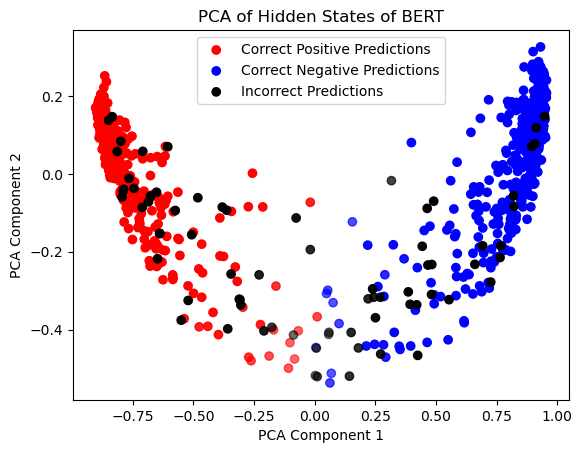

In [122]:
## Plot the data
import matplotlib.pyplot as plt

plt.scatter(transformed_correct_positive_predictions[:,0], 
            transformed_correct_positive_predictions[:,1], 
            label='Correct Positive Predictions', 
            color='red', 
            alpha=correct_positive_predictions_confidence)
plt.scatter(transformed_correct_negative_predictions[:,0], 
            transformed_correct_negative_predictions[:,1], 
            label='Correct Negative Predictions', 
            color='blue', 
            alpha=correct_negative_predictions_confidence)
plt.scatter(transformed_incorrect_predictions[:,0], 
            transformed_incorrect_predictions[:,1], 
            label='Incorrect Predictions', 
            color='black', 
            alpha=incorrect_predictions_confidence)
plt.legend()
plt.title('PCA of Hidden States of BERT')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()